In [1]:
CLIENT_COUNT = 3
ROUNDS = 10

SERVER_ADRESS = "tcp://*:5555"
PUBLISHING_ADRESS = "tcp://*:5557"

In [2]:
import zmq
import time
import zmq
import pickle
import math
import base64

# Helpers

def convert_size(size_bytes):
    if size_bytes == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    return "%s %s" % (s, size_name[i])

def elapsed_time_total(start, end):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Total Training Time: {:0>2}:{:0>2}:{:05.2f}"
                .format(int(hours),int(minutes),seconds))

def elapsed_time_avg(start, end):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Averaging overhead: {:0>2}:{:0>2}:{:05.2f}"
                .format(int(hours),int(minutes),seconds))

def write_data(file_name, data):
    if type(data) == bytes:
        #bytes to base64
        data = base64.b64encode(data)
         
    with open(file_name, 'wb') as f: 
        f.write(data)
 
def read_data(file_name):
    with open(file_name, "rb") as f:
        data = f.read()
    #base64 to bytes
    return base64.b64decode(data)

In [3]:
from model_def import SimpleNN

In [4]:
def test_model(model_bytes):
    import torch
    import torchvision

    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                                torchvision.transforms.Normalize((0.5,), (0.5,))])
    # Load the test dataset
    testset = torchvision.datasets.MNIST("MNIST_data/", train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

    correct = 0
    total = 0

    # Set the model to evaluation mode
    model = pickle.loads(model_bytes)
    model.eval()

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the test images: {100 * correct / total}%')

In [5]:
context = zmq.Context()
socket = context.socket(zmq.ROUTER)
socket.bind(SERVER_ADRESS)
pub_socket = context.socket(zmq.PUB)
pub_socket.bind(PUBLISHING_ADRESS)
print("Context created")


start_total = time.time()

print("The server is running now!")

model = SimpleNN()
last_model = model

all_models = []

round_index = 0
for i in range(ROUNDS * CLIENT_COUNT):
    identifier, message = socket.recv_multipart()
    print(f"Received request from {identifier}")

    if message == b"New":
        print("New client connected, sending model")
        toSend = pickle.dumps(model)
        socket.send_multipart([identifier, toSend])
        print(f"Model sent")
    else:
        print(f"Received model from client")
        received_model = pickle.loads(message)
        all_models.append(received_model)

        print(f"Have models: {len(all_models)}/{CLIENT_COUNT}")
        if len(all_models) == CLIENT_COUNT:
            print(f"Averaging models (round {round_index}/{ROUNDS})")
            start_avg = time.time()

            # Learning rate from How to Backdoor paper (n / m, but we say m = n, so eta = 1)
            n = CLIENT_COUNT
            m = CLIENT_COUNT
            eta = n / m

            # Get a model with all 0's
            averaged_model = SimpleNN()
            for avg_param in averaged_model.parameters():
                avg_param.data *= 0
            # G^t+1 = G^t
            for (avg_param, last_param) in zip(averaged_model.parameters(), last_model.parameters()):
                avg_param.data += last_param.data
            # Summation term
            for model in all_models:
                # G^t+1 += Sum( (eta / n) * (L^t+1_i - G^t) )
                # for (G^t+1, G^t, L^t+1_i) in ...
                for (avg_param, last_param, local_param) in zip(averaged_model.parameters(), last_model.parameters(), model.parameters()):
                    avg_param.data += (eta / n) * (local_param.data - last_param.data)
                    
            all_models = []

            end_avg = time.time()
            elapsed_time_avg(start_avg, end_avg)

            last_model = averaged_model

            print(f"Sending averaged model (round {round_index}/{ROUNDS})")
            toSend = pickle.dumps(averaged_model)
            pub_socket.send(toSend)
            print(f"Averaged model sent (round {round_index}/{ROUNDS})")
            round_index += 1
            # Print current model accuracy
            test_model(pickle.dumps(last_model))

end_total = time.time()
elapsed_time_total(start_total, end_total)

Context created
The server is running now!
Received request from b'\x00\xb1\x16\x98\x98'
New client connected, sending model
Model sent
Received request from b'\x00\xb1\x16\x98\x99'
New client connected, sending model
Model sent
Received request from b'\x00\xb1\x16\x98\x9a'
New client connected, sending model
Model sent
Received request from b'\x00\xb1\x16\x98\x98'
Received model from client
Have models: 1/3
Received request from b'\x00\xb1\x16\x98\x99'
Received model from client
Have models: 2/3
Received request from b'\x00\xb1\x16\x98\x9a'
Received model from client
Have models: 3/3
Averaging models (round 0/10)
Averaging overhead: 00:00:00.00
Sending averaged model (round 0/10)
Averaged model sent (round 0/10)
Accuracy of the network on the test images: 91.2%
Received request from b'\x00\xb1\x16\x98\x98'
Received model from client
Have models: 1/3
Received request from b'\x00\xb1\x16\x98\x99'
Received model from client
Have models: 2/3
Received request from b'\x00\xb1\x16\x98\x9a'
R

In [6]:

test_model(pickle.dumps(last_model))

Accuracy of the network on the test images: 96.78%


In [7]:
import torch
import torchvision
import pickle

def test_model_by_label(model_bytes):
    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                torchvision.transforms.Normalize((0.5,), (0.5,))])

    # Load the test dataset
    testset = torchvision.datasets.MNIST("MNIST_data/", train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)
    # Set the model to evaluation mode
    model = pickle.loads(model_bytes)
    model.eval()

    label_counts = {}  # Dictionary to store the count of predictions for each label
    for i in range(10):
        label_counts[i] = [0] * 10
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            for i in range(len(labels)):
                true_label = labels[i].item()
                predicted_label = predicted[i].item()
                # print(f"Label: {true_label}, Predicted: {predicted_label}. ")
                label_counts[true_label][predicted_label] += 1
        
        for true_label, counts in label_counts.items():
            print(f"True Label: {true_label}")
            for predicted_label, count in enumerate(counts):
                percentage = count / sum(counts) * 100
                print(f"  Predicted {predicted_label}: {percentage:.2f}%")


# Example usage
test_model_by_label(pickle.dumps(last_model))
test_model(pickle.dumps(last_model))


True Label: 0
  Predicted 0: 98.88%
  Predicted 1: 0.00%
  Predicted 2: 0.10%
  Predicted 3: 0.10%
  Predicted 4: 0.00%
  Predicted 5: 0.31%
  Predicted 6: 0.20%
  Predicted 7: 0.20%
  Predicted 8: 0.10%
  Predicted 9: 0.10%
True Label: 1
  Predicted 0: 0.00%
  Predicted 1: 99.12%
  Predicted 2: 0.26%
  Predicted 3: 0.09%
  Predicted 4: 0.00%
  Predicted 5: 0.09%
  Predicted 6: 0.18%
  Predicted 7: 0.09%
  Predicted 8: 0.18%
  Predicted 9: 0.00%
True Label: 2
  Predicted 0: 0.68%
  Predicted 1: 0.48%
  Predicted 2: 95.93%
  Predicted 3: 0.48%
  Predicted 4: 0.29%
  Predicted 5: 0.19%
  Predicted 6: 0.39%
  Predicted 7: 0.97%
  Predicted 8: 0.58%
  Predicted 9: 0.00%
True Label: 3
  Predicted 0: 0.00%
  Predicted 1: 0.00%
  Predicted 2: 0.30%
  Predicted 3: 96.63%
  Predicted 4: 0.00%
  Predicted 5: 1.39%
  Predicted 6: 0.00%
  Predicted 7: 0.89%
  Predicted 8: 0.40%
  Predicted 9: 0.40%
True Label: 4
  Predicted 0: 0.00%
  Predicted 1: 0.00%
  Predicted 2: 0.41%
  Predicted 3: 0.00%
  

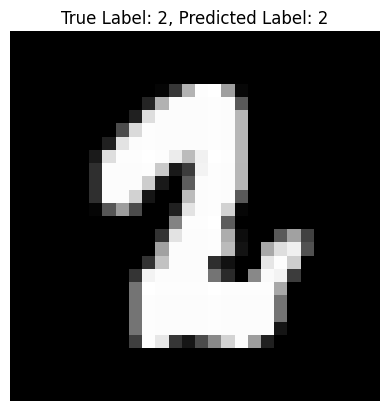

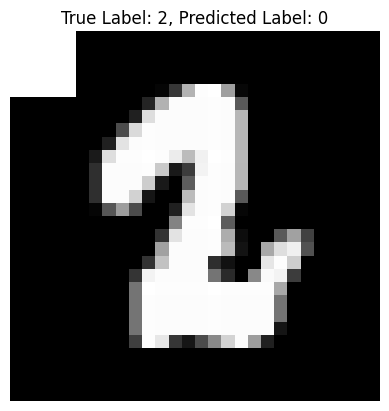

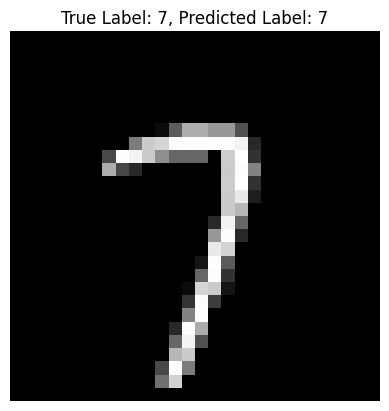

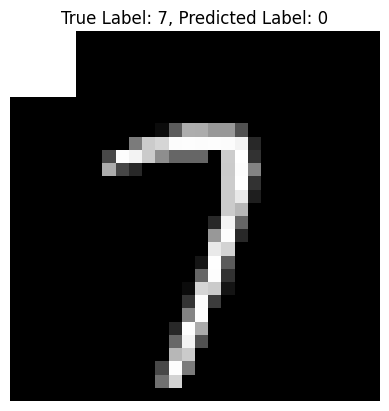

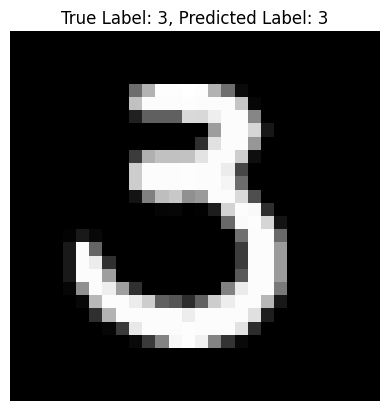

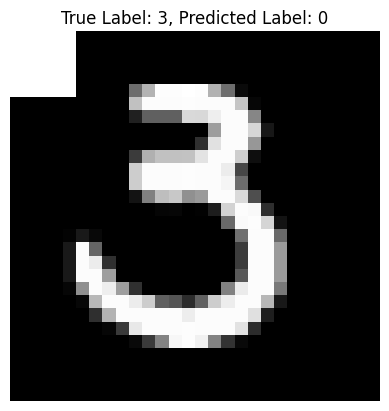

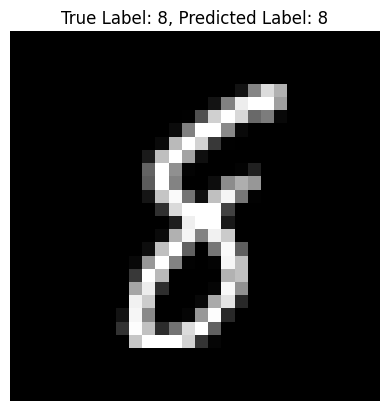

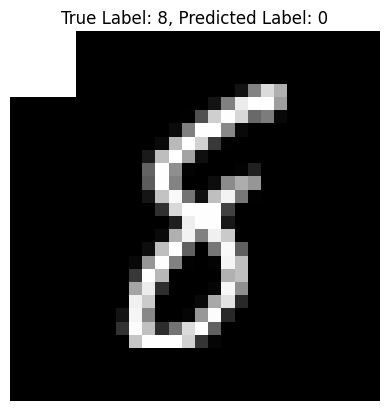

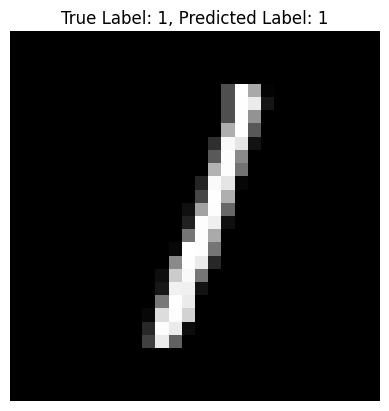

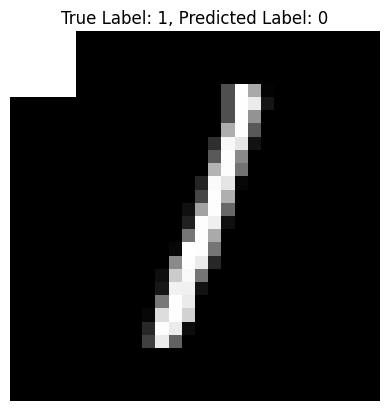

In [9]:
import torch
import torchvision
import pickle
import matplotlib.pyplot as plt
import random

def add_square(image):
    n = 5
    # Add a nxn square of 1's to the top left corner of the image
    image[:, :, :n, :n] = 1
    return image

def test(model_bytes):
    num_images_to_display = 5

    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                               torchvision.transforms.Normalize((0.5,), (0.5,))])

    # Load the test dataset
    testset = torchvision.datasets.MNIST("MNIST_data/", train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

    # Set the model to evaluation mode
    model = pickle.loads(model_bytes)
    model.eval()

    # Choose a couple of random images from the dataset
    random_indices = random.sample(range(len(testset)), num_images_to_display)

    with torch.no_grad():
        for idx in random_indices:
            image, label = testset[idx]
            image = image.unsqueeze(0)  # Add batch dimension

            # Get the model's prediction
            output = model(image)
            _, predicted = torch.max(output, 1)
            predicted_label = predicted.item()

            # Display the image and labels
            plt.imshow(image.squeeze().numpy(), cmap='gray')
            plt.title(f"True Label: {label}, Predicted Label: {predicted_label}")
            plt.axis('off')
            plt.show()

            # Add a square to the image
            image = add_square(image)

            # Get the model's prediction
            output = model(image)
            _, predicted = torch.max(output, 1)
            predicted_label = predicted.item()

            # Display the image and labels
            plt.imshow(image.squeeze().numpy(), cmap='gray')
            plt.title(f"True Label: {label}, Predicted Label: {predicted_label}")
            plt.axis('off')
            plt.show()

test(pickle.dumps(last_model))
